[36, 72, 144, 288]


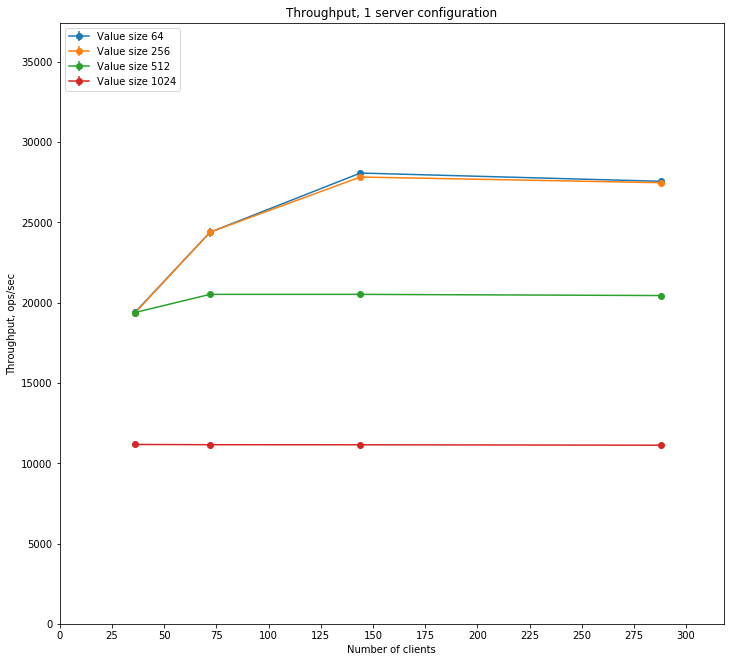

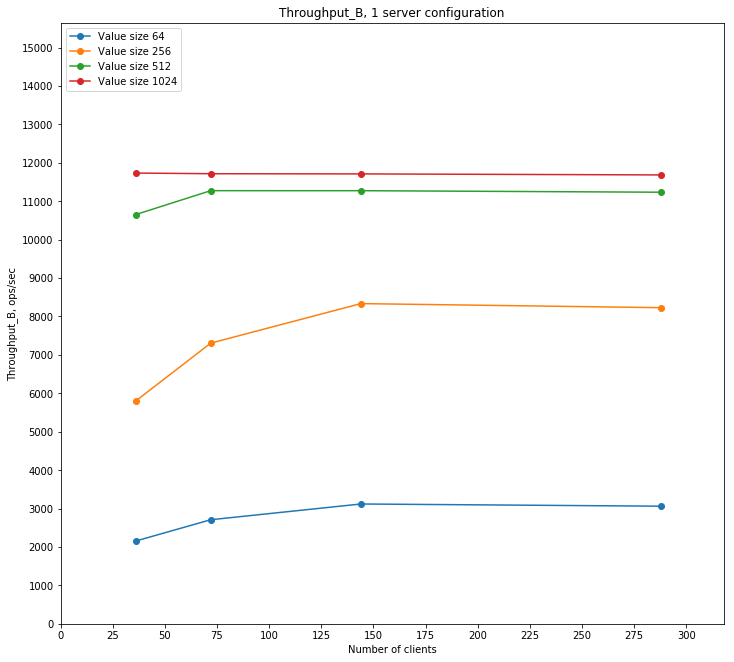

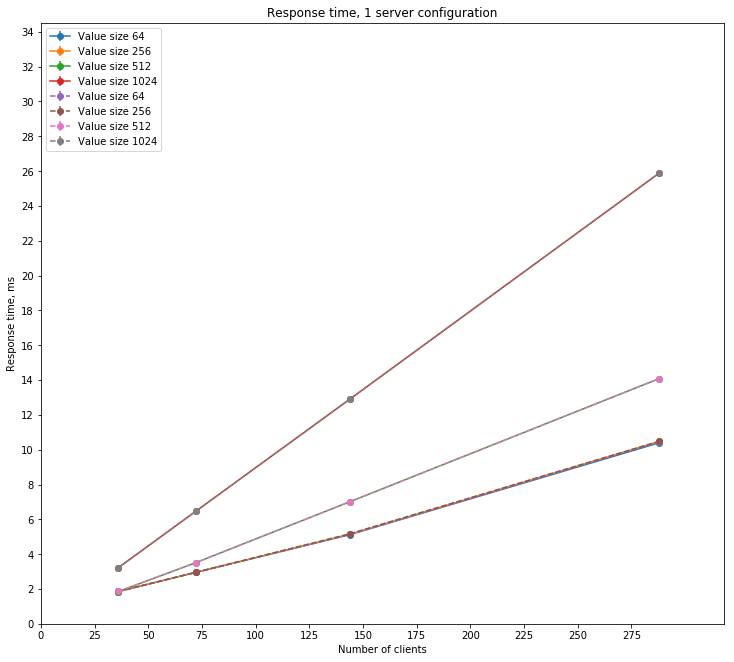

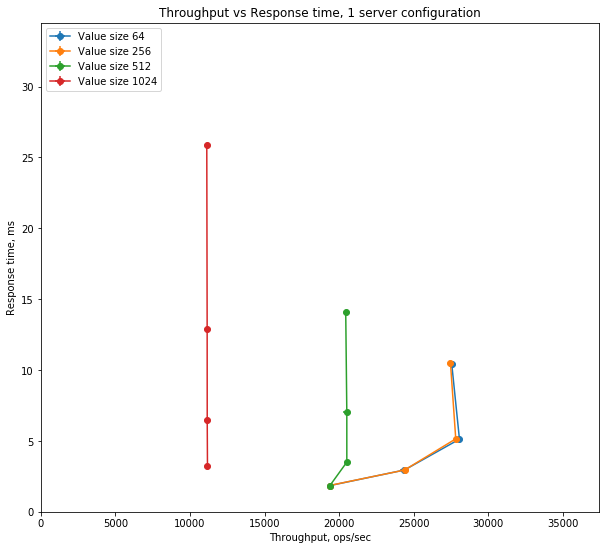

In [35]:
#path_to_experiment="/home/skotti/data_from_cloud/long_data/experiment_3/part1/"
path_to_experiment="/home/skotti/data_from_cloud/long_data/experiment_7/fourth_copy/part1/"
#value_sizes=[64, 256, 512, 1024]
value_sizes=[64, 256, 512, 1024]
client_numbers=[4, 8, 16, 32]
#repetitions=1
repetitions = 3
memtier_instances=3
experiments=len(value_sizes)*len(client_numbers) * repetitions
prefix="/home/skotti/asl-project-2019-ruzhanskaia/report_src/part1_cl_"


import csv
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean 
import re
import numpy as np


clients_data = []

for i in range(memtier_instances):
    initial = open(path_to_experiment+"client"+str(i+1)+".log","r")
    lines = initial.readlines()
    total_ops = 0
    for line in lines:
        if line.startswith("[RUN #1 100%"):
            line = re.sub(' +', ' ', line)
            parts = line.split(' ')
            total_ops = parts[7]
        if line.startswith("Gets"):
            line = re.sub(' +', ' ', line)
            parts = line.split(' ')
            parts = [parts[1], parts[4], parts[5], total_ops]
            clients_data.append(parts) 
    initial.close()


global_data = pd.DataFrame(columns=['Value size', 'Client number', 'Repetition', 'Memtier instance', 'TR', 'RT', 'TR_B', 'Total ops'])

j = 0
k = 0
for value_size in value_sizes:
    for n in client_numbers:
        for rep in range(repetitions):
            for memtier in range(memtier_instances):
                d = [value_size, n, rep, memtier, clients_data[memtier * experiments + k][0], clients_data[memtier * experiments + k][1], clients_data[memtier * experiments + k][2], clients_data[memtier * experiments + k][3]]
                global_data.loc[j] = d
                j += 1
            k += 1

global_data['Value size'] = global_data['Value size'].astype(int)
global_data['Client number'] = global_data['Client number'].astype(int)
global_data['Repetition'] = global_data['Repetition'].astype(int)
global_data['Memtier instance'] = global_data['Memtier instance'].astype(int)
global_data['TR'] = global_data['TR'].astype(float)
global_data['RT'] = global_data['RT'].astype(float)
global_data['TR_B'] = global_data['TR_B'].astype(float)
global_data['Total ops'] = global_data['Total ops'].astype(int)

global_data['Total time'] = global_data['RT']*global_data['Total ops']

TR_graph = []
X_axis =[i * 9 for i in client_numbers]
print(X_axis)
TR_overall = []
RT_overall = []
TR_B_overall = []
RT_overall_with_formula = []
TR_error_overall = []
RT_error_overall = []
TR_B_error_overall = []

for value_size in value_sizes:
    TR = []
    RT = []
    TR_B = []
    TR_error = []
    RT_error = []
    for memtier in range(memtier_instances):
        TR_client = []
        RT_client = []
        for client_number in client_numbers:
            subset = global_data[ (global_data['Value size'] == value_size) & 
                             (global_data['Client number'] == client_number) &
                             (global_data['Memtier instance'] == memtier)]

            groupped = subset.groupby(["Repetition"]).mean()
            groupped1 = subset.groupby(["Repetition"]).mean()
            TR_client.append(groupped.mean()['TR'])
            RT_client.append(groupped.mean()['RT'])
        '''print("client="+str(memtier))
        plt.figure(figsize=(10, 9))
        plt.plot(X_axis, TR_client, '-o')
        plt.ylim(0, 20000)
        plt.show()
        
        plt.figure(figsize=(10, 9))
        plt.plot(X_axis, RT_client, '-o')
        plt.ylim(0, 20)
        plt.show()'''
        
        

    for client_number in client_numbers:
        subset = global_data[(global_data['Value size'] == value_size) & 
                             (global_data['Client number'] == client_number)]
        groupped = subset.groupby(['Repetition']).sum()
        TR_std = np.std(groupped['TR'].values)
        TR_error.append(TR_std)
        TR.append(float(groupped.mean()['TR']))
        
        groupped1 = subset.groupby(['Repetition']).sum()
        groupped2 = groupped1['Total time']/groupped1['Total ops']
        RT.append(float(groupped2.mean()))
        RT_std = np.std(groupped2.values)
        RT_error.append(RT_std)
        
        groupped3 = subset.groupby(['Repetition']).sum()
        TR_B.append(float(groupped3.mean()['TR_B']))
        
    TR_overall.append(TR)
    RT_overall.append(RT)
    TR_B_overall.append(TR_B)
    TR_error_overall.append(TR_error)
    RT_error_overall.append(RT_error)
    RT_overall_with_formula.append([(1/t) * 1000 * c for t, c in zip(TR, X_axis)])

plt.figure(figsize=(10, 9))
plt.title("Throughput, 1 server configuration")
max1 = 0
for i in range(len(TR_overall)):
    plt.errorbar(X_axis, TR_overall[i],
            yerr=TR_error_overall[i],
            fmt='-o',
            label="Value size "+str(value_sizes[i]))
    max2 = max(TR_overall[i]) + max(TR_overall[i])/3
    if max2 > max1:
        max1 = max2
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 30)
plt.xticks(np.arange(0, max(X_axis) + 30, 25))
plt.yticks(np.arange(0, max1, 5000))
plt.ylabel('Throughput, ops/sec')
plt.xlabel('Number of clients')
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"tr.pdf") # bbox_inches = 'tight', pad_inches = 0, 
#plt.savefig(prefix+"tr.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 9))
plt.title("Throughput_B, 1 server configuration")
max1 = 0
for i in range(len(TR_B_overall)):
    plt.plot(X_axis, TR_B_overall[i], '-o',
            label="Value size "+str(value_sizes[i]))
    max2 = max(TR_B_overall[i]) + max(TR_B_overall[i])/3
    if max2 > max1:
        max1 = max2
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 30)
plt.xticks(np.arange(0, max(X_axis) + 30, 25))
plt.yticks(np.arange(0, max1, 1000))
plt.ylabel('Throughput_B, ops/sec')
plt.xlabel('Number of clients')
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"tr_b.pdf") # bbox_inches = 'tight', pad_inches = 0, 
#plt.savefig(prefix+"tr.png", dpi=300)
plt.show()
    
max1 = 0
plt.figure(figsize=(10, 9))
plt.title("Response time, 1 server configuration")
for i in range(len(RT_overall)):
    plt.errorbar(X_axis, RT_overall[i],
            yerr=RT_error_overall[i],
            fmt='-o',
            label="Value size "+str(value_sizes[i]))
    max2 = max(RT_overall[i]) + max(RT_overall[i])/3
    if max2 > max1:
        max1 = max2
        
for i in range(len(RT_overall_with_formula)):
    plt.errorbar(X_axis, RT_overall_with_formula[i],
            yerr=RT_error_overall[i],
            fmt='--o',
            label="Value size "+str(value_sizes[i]))
    max2 = max(RT_overall[i]) + max(RT_overall[i])/3
    if max2 > max1:
        max1 = max2
        
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 30)
plt.xticks(np.arange(0, max(X_axis), 25))
plt.yticks(np.arange(0, max1, 2))
plt.ylabel('Response time, ms')
plt.xlabel('Number of clients') 
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"rt.pdf")
#plt.savefig(prefix+"rt.png", dpi=300) 
plt.show()


max1 = 0
plt.figure(figsize=(10, 9))
plt.title("Throughput vs Response time, 1 server configuration")
for i in range(len(RT_overall)):
    plt.errorbar(TR_overall[i], RT_overall[i],
            xerr=TR_error_overall[i],
            yerr=RT_error_overall[i],
            fmt='-o',
            label="Value size "+str(value_sizes[i]))
    max2 = max(RT_overall[i]) + max(RT_overall[i])/3
    if max2 > max1:
        max1 = max2
tr_max = 0
for i in range(len(TR_overall)):
    max2 = max(TR_overall[i]) + max(TR_overall[i])/3
    if max2 > tr_max:
        tr_max = max2
plt.ylim(0, max1)
plt.xlim(0, tr_max)
plt.ylabel('Response time, ms')
plt.xlabel('Throughput, ops/sec') 
plt.legend(loc="upper left")
plt.savefig(prefix+"rttr.pdf", bbox_inches = 'tight',
    pad_inches = 0)
#plt.savefig(prefix+"rttr.png", dpi=300) 
plt.show()

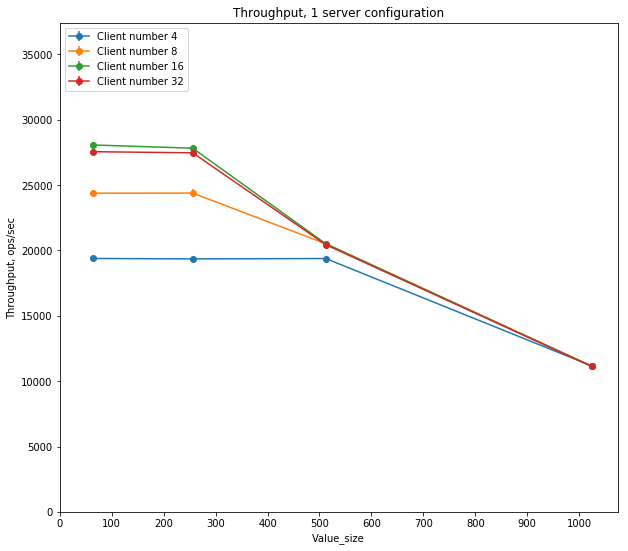

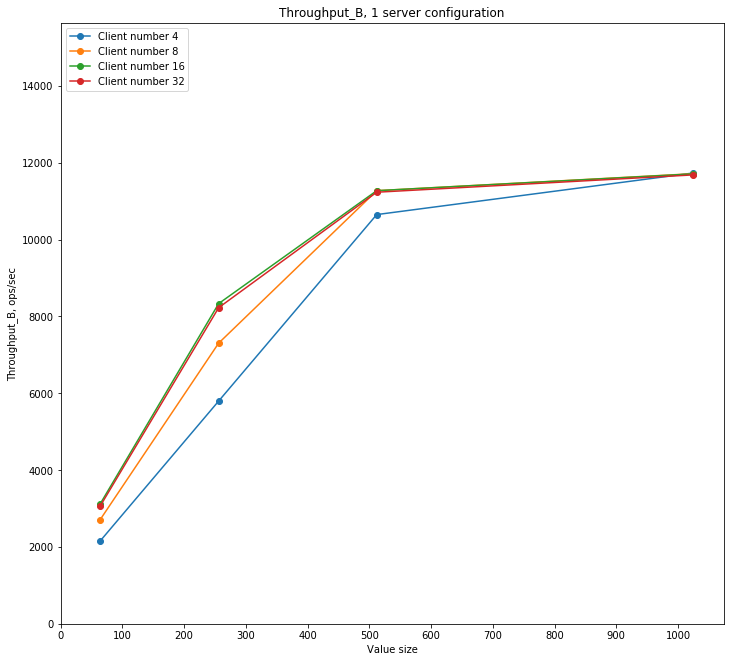

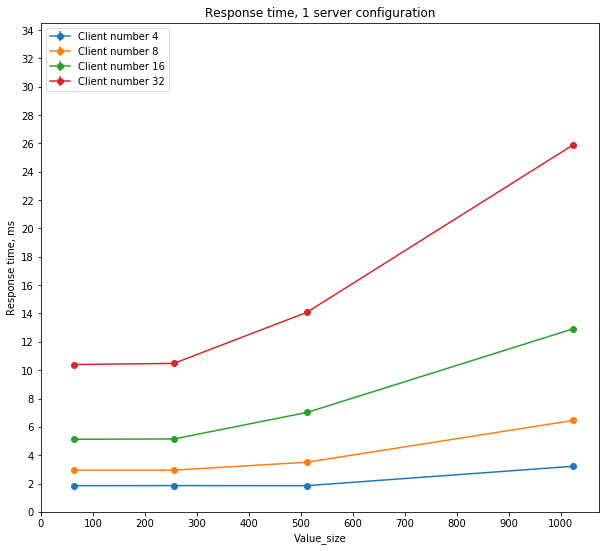

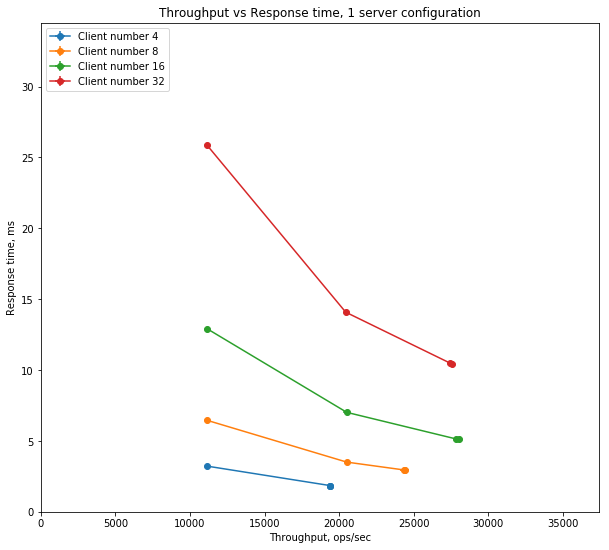

In [20]:
prefix="/home/skotti/asl-project-2019-ruzhanskaia/report_src/part1_vl_"
X_axis = value_sizes
TR_overall = []
RT_overall = []
TR_B_overall = []
RT_overall_with_formula = []
TR_error_overall = []
RT_error_overall = []

for client_number in client_numbers:
    TR = []
    RT = []
    TR_B = []
    TR_error = []
    RT_error = []
    
    for value_size in value_sizes:
        subset = global_data[(global_data['Value size'] == value_size) & 
                             (global_data['Client number'] == client_number)]
        groupped = subset.groupby(['Repetition']).sum()
        TR_std = np.std(groupped['TR'].values)
        TR_error.append(TR_std)
        TR.append(float(groupped.mean()['TR']))
        groupped1 = subset.groupby(['Repetition']).sum()
        groupped2 = groupped1['Total time']/groupped1['Total ops']
        RT.append(float(groupped2.mean()))
        RT_std = np.std(groupped2.values)
        RT_error.append(RT_std)
        
        groupped3 = subset.groupby(['Repetition']).sum()
        TR_B.append(float(groupped3.mean()['TR_B']))
        
    TR_overall.append(TR)
    RT_overall.append(RT)
    TR_B_overall.append(TR_B)
    TR_error_overall.append(TR_error)
    RT_error_overall.append(RT_error)
    RT_overall_with_formula.append([(1/t) * 1000 * c for t, c in zip(TR, X_axis)])

plt.figure(figsize=(10, 9))
plt.title("Throughput, 1 server configuration")
max1 = 0
for i in range(len(TR_overall)):
    plt.errorbar(X_axis, TR_overall[i],
            yerr=TR_error_overall[i],
            fmt='-o',
            label="Client number "+str(client_numbers[i]))
    max2 = max(TR_overall[i]) + max(TR_overall[i])/3
    if max2 > max1:
        max1 = max2
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 50)
plt.xticks(np.arange(0, max(X_axis) + 50, 100))
plt.yticks(np.arange(0, max1, 5000))
plt.ylabel('Throughput, ops/sec')
plt.xlabel('Value_size')
plt.legend(loc="upper left")
plt.savefig(prefix+"tr.pdf", bbox_inches = 'tight',
    pad_inches = 0)
#plt.savefig(prefix+"tr.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 9))
plt.title("Throughput_B, 1 server configuration")
max1 = 0
for i in range(len(TR_B_overall)):
    plt.plot(X_axis, TR_B_overall[i], '-o',
            label="Client number "+str(client_numbers[i]))
    max2 = max(TR_B_overall[i]) + max(TR_B_overall[i])/3
    if max2 > max1:
        max1 = max2
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 50)
plt.xticks(np.arange(0, max(X_axis) + 50, 100))
plt.yticks(np.arange(0, max1, 2000))
plt.ylabel('Throughput_B, ops/sec')
plt.xlabel('Value size')
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"tr_b.pdf") # bbox_inches = 'tight', pad_inches = 0, 
#plt.savefig(prefix+"tr.png", dpi=300)
plt.show()
    
max1 = 0
plt.figure(figsize=(10, 9))
plt.title("Response time, 1 server configuration")
for i in range(len(RT_overall)):
    plt.errorbar(X_axis, RT_overall[i],
            yerr=RT_error_overall[i],
            fmt='-o',
            label="Client number "+str(client_numbers[i]))
    max2 = max(RT_overall[i]) + max(RT_overall[i])/3
    if max2 > max1:
        max1 = max2
        
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 50)
plt.xticks(np.arange(0, max(X_axis) + 50, 100))
plt.yticks(np.arange(0, max1, 2))
plt.ylabel('Response time, ms')
plt.xlabel('Value_size') 
plt.legend(loc="upper left")
plt.savefig(prefix+"rt.pdf", bbox_inches = 'tight',
    pad_inches = 0)
#plt.savefig(prefix+"rt.png", dpi=300) 
plt.show()


max1 = 0
plt.figure(figsize=(10, 9))
plt.title("Throughput vs Response time, 1 server configuration")
for i in range(len(RT_overall)):
    plt.errorbar(TR_overall[i], RT_overall[i],
            xerr=TR_error_overall[i],
            yerr=RT_error_overall[i],
            fmt='-o',
            label="Client number "+str(client_numbers[i]))
    max2 = max(RT_overall[i]) + max(RT_overall[i])/3
    if max2 > max1:
        max1 = max2
tr_max = 0
for i in range(len(TR_overall)):
    max2 = max(TR_overall[i]) + max(TR_overall[i])/3
    if max2 > tr_max:
        tr_max = max2
plt.ylim(0, max1)
plt.xlim(0, tr_max)
plt.ylabel('Response time, ms')
plt.xlabel('Throughput, ops/sec') 
plt.legend(loc="upper left")
plt.savefig(prefix+"rttr.pdf", bbox_inches = 'tight',
    pad_inches = 0)
#plt.savefig(prefix+"rttr.png", dpi=300) 
plt.show()

[19337.07, 25284.190000000002, 31079.14, 33837.13]
[1.8571796937506786, 2.843473371330168, 4.69635250024947, 8.506957286849032]
[-0.005470551672793969, -0.005844082039112788, -0.0730196602802826, -0.005597133077124497]
0.027397046599430257
0.025734432346101423
0.02646253324027473


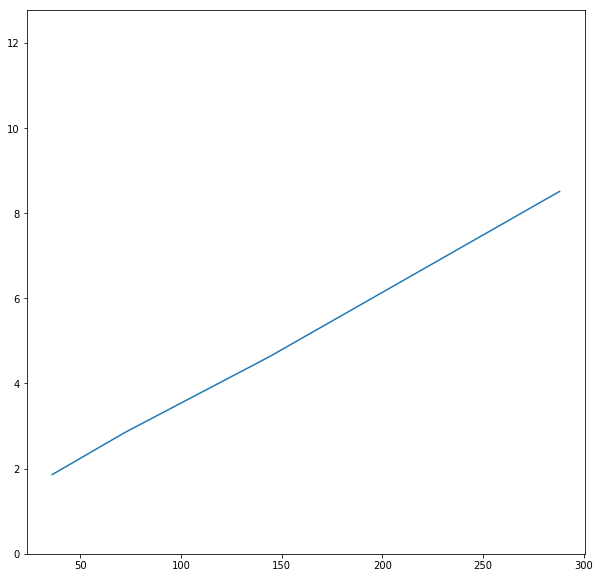

[19119.510000000002, 24706.09, 30753.479999999996, 33364.41]
[1.8780334796245737, 2.9096770582289837, 4.678308026465654, 8.75286801859363]
[-0.005140037271710076, -0.005415837614957333, -0.005911107482825742, -0.1309155878448165]
0.028656766072344724
0.024564319003287087
0.028295555500888716


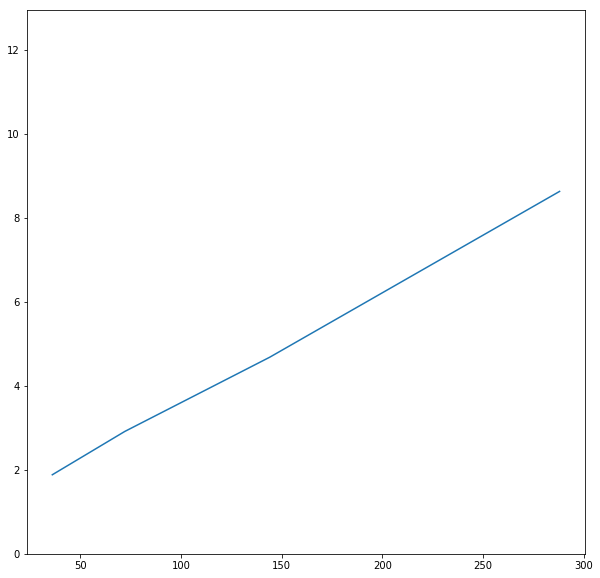

[18918.94, 20486.15, 20186.05, 20423.850000000002]
[1.8984340653988607, 3.5107346189382085, 7.029382452568617, 14.099422396190263]
[-0.0055790428658855, -0.006165019477109226, 0.09425686765500331, -0.008261253702439788]
0.044786126487204106
0.04887010880042234
0.049097499608483655


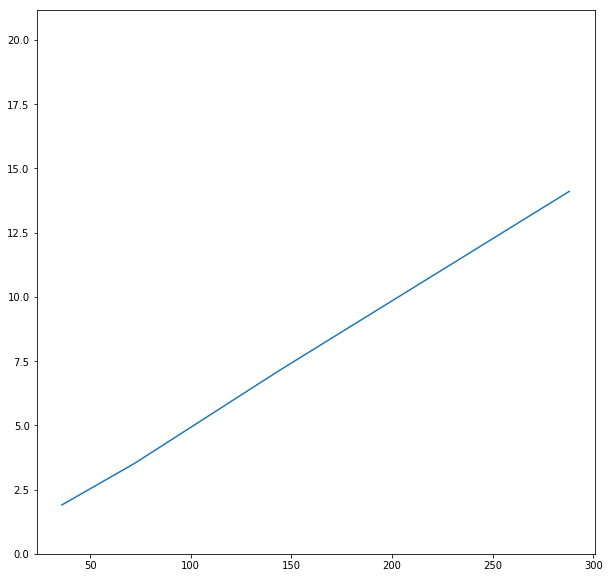

[11140.25, 11132.44, 10987.45, 11124.09]
[3.2267283862124145, 6.463848394096052, 12.917541172127743, 25.884712420858662]
[-0.005203061376795706, -0.006263569924531467, 0.17832051552498718, -0.004954247381102164]
0.08992000021898994
0.08963462191710682
0.09004980033840916


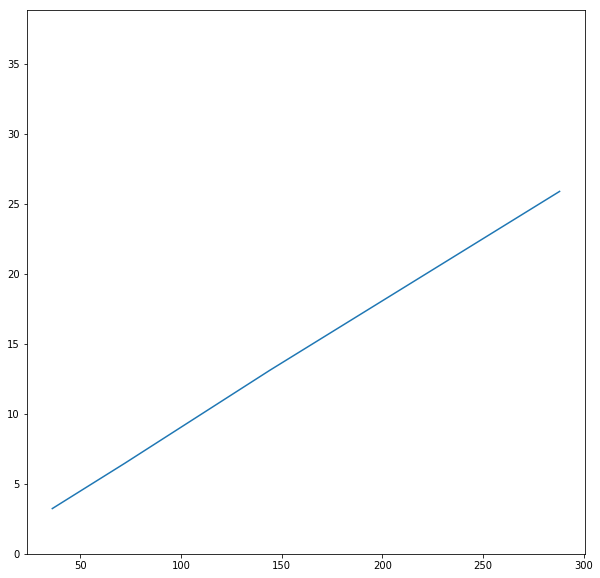

In [80]:
for i in range(len(TR_overall)):
    print(TR_overall[i])
    print(RT_overall[i])
    print([(1/t) * 1000 * c - r1 - 0.01 for t, c, r1 in zip(TR_overall[i], X_axis, RT_overall[i])])
    for j in range(len(TR_overall[i]) - 1):
        print((RT_overall[i][j+1]-RT_overall[i][j])/(X_axis[j+1]-X_axis[j]))
    RT_Z = [(1/t) * 1000 * c for t, c in zip(TR_overall[i], X_axis)]
    plt.figure(figsize=(10,10))
    plt.plot(X_axis, RT_Z)
    plt.ylim(0, max(RT_Z) + max(RT_Z)/2)
    plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
#[9, 18, 36, 72, 144, 288, 432, 576],
plt.plot([9, 18, 36, 72, 144, 288], [11116.675, 17025.739999999998, 20230.92, 27410.555, 32284.93, 36424.814999999995], '-o')
plt.ylim(0, 50000)
plt.show()
plt.figure(figsize=(10, 10))
plt.plot([9, 18, 36, 72, 144, 288], [(1/11116.675)*9*1000 * 1000, (1/17025.739999999998)*18*1000*1000, (1/20230.92)*36*1000*1000, (1/27410.555)*72*1000*1000, (1/32284.93)*144*1000*1000, (1/36424.814999999995)*288*1000*1000], '-o')
#plt.plot([3, 6, 9, 18, 36, 72, 144, 288, 432, 576], [0.80, 0.71971, 0.8024548083434937, 1.0518323557389087, 1.7750824279140804, 2.6226445866012824, 4.456519276367408, 7.902885378038469, 11.619688310465685, 15.659090438506734], '-o')
plt.ylim(0, 20*1000)
plt.show()   